In [1]:
import numpy as np
import astropy as astropy
from astropy.table import QTable
# Set up matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from astropy import units as u
import matplotlib.pyplot as plt
from astropy import constants as const
import lmfit
import matplotlib as mpl
from astropy.io import fits
import tabulate
import pandas as pd
from lmfit import Parameters
from uncertainties import ufloat
import math
from array import array

In [2]:
import corner

In [3]:
mask_array = fits.open('dendrogram_mask_pruned_rms3e6_k14_dv3_dd1_dp17_pp6_pm2_gal_02-02-20.fits')
data_mask = mask_array[0].data
header_mask = mask_array[0].header

In [4]:
image_3um = fits.open('mosaic_3um_reprojected_to_500um.fits')
data_3um = image_3um[0].data
header_3um = image_3um[0].header

image_5um = fits.open('mosaic_5um_reprojected_to_500um.fits')
data_5um = image_5um[0].data
header_5um = image_5um[0].header

image_8um = fits.open('mosaic_8um_reprojected_to_500um.fits')
data_8um = image_8um[0].data
header_8um = image_8um[0].header

image_12um = fits.open('mosaic_12um_reprojected_to_500um.fits')
data_12um = image_12um[0].data
header_12um = image_12um[0].header

image_22um = fits.open('mosaic_22um_reprojected_to_500um.fits')
data_22um = image_22um[0].data
header_22um = image_22um[0].header

image_24um = fits.open('mosaic_24um_reprojected_to_500um.fits')
data_24um = image_24um[0].data
header_24um = image_24um[0].header

image_25um = fits.open('mosaic_25um_reprojected_to_500um.fits')
data_25um = image_25um[0].data
header_25um = image_25um[0].header

image_37um = fits.open('mosaic_37um_reprojected_to_500um.fits')
data_37um = image_37um[0].data
header_37um = image_37um[0].header

image_70um = fits.open('mosaic_70um_reprojected_to_500um.fits')
data_70um = image_70um[0].data
header_70um = image_70um[0].header

image_160um = fits.open('mosaic_160um_reprojected_to_500um.fits')
data_160um = image_160um[0].data
header_160um = image_160um[0].header

image_250um = fits.open('mosaic_250um_reprojected_to_500um.fits')
data_250um = image_250um[0].data
header_250um = image_250um[0].header

image_500um = fits.open('mosaic_500um_reprojected_to_500um.fits')
data_500um = image_500um[0].data
header_500um = image_500um[0].header

image_1300um = fits.open('mosaic_cmzoom_reprojected_to_500um.fits')
data_1300um = image_1300um[0].data
header_1300um = image_1300um[0].header

In [5]:
# Code below is for the mask Stuff

In [5]:
from astropy.table import Table 
from astropy.table import hstack
from astropy.table import Column
catalog = Table.read('megacatalog_team_acc_final_say.fits')

In [6]:
# Some useful constants
h       = const.h.to(u.erg * u.s).value
k       = const.k_B.to(u.erg / u.K).value
c       = const.c.to(u.cm / u.s).value
mmp     = 2.8
mh      = const.m_p.to(u.g).value

G = 6.67408e-11
msun = 1.989e33
pc2cm = 3.08567758e18
as2persr = 4.25e10 
percm2perm = 1.0e6
hplanck = 6.63e-34
clight = 2.99792e8
kboltzmann = 1.381e-23
sin1yr = 3.15569e7

In [57]:
def blackbody_freq_C(freq, d2g, T_l, T_m, T_h, N_l, N_m, N_h): 

### dust opacity constants
    k0      = 4.0   
    beta    = 2.5
    freq0   = 505e9
    ### dust opacity
    kv      = d2g * k0 * (freq/freq0)**beta
    
    tau_l   = mmp * mh * kv * N_l
    tau_m   = mmp * mh * kv * N_m
    tau_h   = mmp * mh * kv * N_h
    
    F_l     = (2*h*freq**3 / (c**2 * (np.exp(h*freq / (k*T_l)) - 1)))
    F_m     = (2*h*freq**3 / (c**2 * (np.exp(h*freq / (k*T_m)) - 1)))
    F_h     = (2*h*freq**3 / (c**2 * (np.exp(h*freq / (k*T_h)) - 1)))
    
    F1_l    = (F_l * (1 - np.exp(-tau_l)))
    F1_m    = (F_m * (1 - np.exp(-tau_m)))
    F1_h    = (F_h * (1 - np.exp(-tau_h)))
    
    I_l     = (F1_l * 1.e23 / 1.e6)
    I_m     = (F1_m * 1.e23 / 1.e6)
    I_h     = (F1_h * 1.e23 / 1.e6)

    return (I_l + I_h + I_m)

In [8]:
L1 = catalog['index']
SGA = np.zeros(len(catalog['index']))
SGB = np.zeros(len(catalog['index']))

for i in range(len(catalog['index'])):
    if catalog['leaf_ID'][i][:8] == 'G359.948':
        SGA[i] = 1
    else:
        SGA[i] = 0
        
    if catalog['leaf_ID'][i][:6] == 'G0.699':
        SGB[i] = 1
    else:
        SGB[i] = 0
        
L2 = catalog['index'][np.where(SGA == 0)].data
L4 = catalog['index'][np.where(SGB == 0)].data

In [19]:
L3 = list(set(L2)|set(L4))
L3.sort()

In [21]:
# data= an array of the edata points being passed through
## fit_func should accept the simplified balckbody function w/ 1 independent variable
def NormalizedChiSquare(wavelengths, data, fit_func):
    ChiSquare = np.sum((data - fit_func)**2/weights**2)
    return ChiSquare

In [22]:
LF_Arr = np.empty([len(L3), 9]) #Vary b/o input WL
Missing_25um = np.zeros([len(L3)])
Missing_37um = np.zeros([len(L3)])


for i in range(len(L3)):
    Leaf_ID = L3[i]
    
    mask_condition = data_mask == Leaf_ID

    leaf_data_3um = data_3um[np.where(mask_condition == True)]
    
    
    mask_condition = data_mask == Leaf_ID

    leaf_data_5um = data_5um[np.where(mask_condition == True)]
    
    
    mask_condition = data_mask == Leaf_ID

    leaf_data_8um = data_8um[np.where(mask_condition == True)]
    
    
    mask_condition = data_mask == Leaf_ID

    leaf_data_12um = data_12um[np.where(mask_condition == True)]
    
    
    mask_condition = data_mask == Leaf_ID

    leaf_data_22um = data_22um[np.where(mask_condition == True)]
    
    
    mask_condition = data_mask == Leaf_ID

    leaf_data_24um = data_24um[np.where(mask_condition == True)]
 
    
    mask_condition = data_mask == Leaf_ID

    leaf_data_25um = data_25um[np.where(mask_condition == True)]

  
    mask_condition = data_mask == Leaf_ID

    leaf_data_37um = data_37um[np.where(mask_condition == True)]


    mask_condition = data_mask == Leaf_ID

    leaf_data_70um = data_70um[np.where(mask_condition == True)]

    
    mask_condition = data_mask == Leaf_ID

    leaf_data_160um = data_160um[np.where(mask_condition == True)]


    mask_condition = data_mask == Leaf_ID

    leaf_data_250um = data_250um[np.where(mask_condition == True)]


    mask_condition = data_mask == Leaf_ID

    leaf_data_500um = data_500um[np.where(mask_condition == True)]
    
    
    mask_condition = data_mask == Leaf_ID

    leaf_data_1300um = data_1300um[np.where(mask_condition == True)]

    if np.any(leaf_data_25um > 0):
        leaf_data_22um = 0 
    elif np.any(leaf_data_25um == 0):
        leaf_data_22um = leaf_data_22um
    
    LF_Arr[i, :] = np.array([np.mean(leaf_data_8um), 
                             #np.mean(leaf_data_12um), 
                             np.mean(leaf_data_22um),
                             np.mean(leaf_data_25um)/(10**6)*(1.7033*10**11), 
                             np.mean(leaf_data_37um)/(10**6)*(1.7033*10**11), 
                             np.mean(leaf_data_70um),
                             np.mean(leaf_data_160um), 
                             np.mean(leaf_data_250um), 
                             np.mean(leaf_data_500um),
                             np.mean(leaf_data_1300um)/(10**6)])
                                                            
    

    if np.any(leaf_data_25um <= 0 ):
        Missing_25um[i] = 1
    else:
        Missing_25um[i] = 0

    if np.any(leaf_data_37um <= 0 ):
        Missing_37um[i] = 1
    else:
        Missing_37um[i] = 0


In [23]:
LF_Arr = LF_Arr.astype('float')
LF_Arr[LF_Arr == 0] = 'nan' 

In [ ]:
fit_comb_T_l = np.zeros([len(L3)])
fit_comb_T_m = np.zeros([len(L3)])
fit_comb_T_h = np.zeros([len(L3)])
fit_comb_N_l = np.zeros([len(L3)])
fit_comb_N_m = np.zeros([len(L3)])
fit_comb_N_h = np.zeros([len(L3)])
uncert_d2g = np.zeros([len(L3)])
d2g = np.zeros([len(L3)])
uncert_T_l = np.zeros([len(L3)])
uncert_T_m = np.zeros([len(L3)])
uncert_T_h = np.zeros([len(L3)])
uncert_N_l = np.zeros([len(L3)])
uncert_N_m = np.zeros([len(L3)])
uncert_N_h = np.zeros([len(L3)])

prcnt_low = np.zeros([len(L3)])
prcnt_mid = np.zeros([len(L3)])
prcnt_high = np.zeros([len(L3)])

avg_temp = np.zeros([len(L3)])
avg_dens = np.zeros([len(L3)])

ChiSqr = np.zeros([len(L3)])

for i in range(len(L3)):

                         
    curve_freqs = np.linspace(1e11, 1e15, 5000)
    
    real_wl = np.array([8.0e-6, 
                        #12.0e-6, 
                        22.0e-6,
                        25.0e-6, 
                        37.0e-6, 
                        70.0e-6,
                        160.0e-6, 
                        250.0e-6, 
                        500.0e-6,
                        1300.0e-6])*100.0

    real_freqs = c/(real_wl)

    RD_comb = lmfit.Model(blackbody_freq_C) 
    params = RD_comb.make_params()
    
    weights = np.array([1./1.002744, (1./1.02), 
                        1./1.0030536, 
                        (1./1.06), (1./1.06),
                        (1./1.325),(1./1.325),
                        (1./1.325),(1./1.325)], dtype = np.float64)

    params.add('d2g', value = (1./100.), vary = True, min = (1./400.) , max = (1./25.)) 
    params.add('T_l', value = 20,  vary = True, min = 5, max = None)
    params.add('T_m', value = 35, vary = True, min = 10, max = None)
    params.add('T_h', value = 200, vary = True, min = 100, max = 300)
    params.add('N_l', value = 10e21,vary = True, min = 10e10, max = 10e27)
    params.add('N_m', value = 10e19,vary = True, min = 10e10, max = 10e26)
    params.add('N_h', value = 10e15,vary = True, min = 10e14, max = 10e23)
    
    result_comb = RD_comb.fit(LF_Arr[i, :], params, freq = real_freqs,  nan_policy='omit', method = 'emcee')
    fit_comb_T_l[i] = result_comb.params['T_l'].value
    fit_comb_T_m[i] = result_comb.params['T_m'].value
    fit_comb_T_h[i] = result_comb.params['T_h'].value

    fit_comb_N_l[i] = result_comb.params['N_l'].value
    fit_comb_N_m[i] = result_comb.params['N_m'].value
    fit_comb_N_h[i] = result_comb.params['N_h'].value
    d2g[i] = result_comb.params['d2g'].value
    
    uncert_T_l[i] = result_comb.params['T_l'].stderr
    uncert_T_m[i] = result_comb.params['T_m'].stderr
    uncert_T_h[i] = result_comb.params['T_h'].stderr

    uncert_N_l[i] = result_comb.params['N_l'].stderr
    uncert_N_m[i]  = result_comb.params['N_m'].stderr
    uncert_N_h[i] = result_comb.params['N_h'].stderr
    uncert_d2g[i] = result_comb.params['d2g'].stderr
    
    prcnt_low[i] = (fit_comb_N_l[i])/((fit_comb_N_l[i]) + (fit_comb_N_m[i]) + (fit_comb_N_h[i]))
    prcnt_mid[i] = (fit_comb_N_m[i])/((fit_comb_N_l[i]) + (fit_comb_N_m[i]) + (fit_comb_N_h[i]))
    prcnt_high[i] = (fit_comb_N_h[i])/((fit_comb_N_l[i]) + (fit_comb_N_m[i]) + (fit_comb_N_h[i]))
    
    avg_temp[i] = (prcnt_low[i]*fit_comb_T_l[i]) + (prcnt_mid[i]*fit_comb_T_m[i]) + (prcnt_high[i]*fit_comb_T_h[i])
    avg_dens[i] = (prcnt_low[i]*fit_comb_N_l[i]) + (prcnt_mid[i]*fit_comb_N_m[i]) + (prcnt_high[i]*fit_comb_N_h[i])
    
    ChiSqr[i] = result_comb.redchi

100%|██████████| 1000/1000 [00:16<00:00, 60.05it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [116.41598483 119.11354781  80.87419324  81.58258927 125.97837243
 120.65297965  92.10457553]


100%|██████████| 1000/1000 [00:15<00:00, 63.94it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [131.19619555 117.78884386 104.42963346 109.31168871 133.29783297
 102.1594784   76.94128275]


100%|██████████| 1000/1000 [00:15<00:00, 62.75it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [120.13775945 119.86862001  43.93237613  83.47007278 135.43759785
 108.51101792 105.23437305]


100%|██████████| 1000/1000 [00:16<00:00, 60.55it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [ 64.76637639 114.64645824  53.31558521  79.37828075 133.1707405
 132.57462018 108.38566657]


100%|██████████| 1000/1000 [00:16<00:00, 60.65it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [101.30588973 119.46313373 112.69856304  81.50839762 129.54536254
  53.78867907  87.70195276]


100%|██████████| 1000/1000 [00:15<00:00, 63.83it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [135.79027845  48.01673684  72.99929059 117.95028454 100.2608319
 131.01853099 125.43746919]


100%|██████████| 1000/1000 [00:16<00:00, 59.06it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [ 86.32648034 109.0394054   93.95936029 117.70475126  97.45587711
 132.92947502 109.38377394]


100%|██████████| 1000/1000 [00:17<00:00, 55.78it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [131.87774999 119.29114313  47.76366562 108.00651959 135.16791589
 112.31659394 120.46927337]


100%|██████████| 1000/1000 [00:16<00:00, 59.94it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [121.81875818 103.50924552  57.09568775  95.28254805 133.51376495
 115.40907699  75.14429574]


100%|██████████| 1000/1000 [00:16<00:00, 60.81it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [116.74871561 105.36610442  44.44599009  88.37715932 123.38646286
 127.49053703 121.16944265]


100%|██████████| 1000/1000 [00:17<00:00, 58.77it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [136.34388778 120.74383712  67.55799163  79.21830768 131.84992573
 131.86579937  63.30038184]


100%|██████████| 1000/1000 [00:17<00:00, 55.93it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [ 83.55677338 134.98169396  79.96142184  57.47689432 132.59823206
 134.14467874  43.19333285]


100%|██████████| 1000/1000 [00:15<00:00, 63.20it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [128.60077639 116.96566439  58.30604562 105.87106895 134.30533361
 132.82004068 118.03591223]


100%|██████████| 1000/1000 [00:16<00:00, 61.49it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [128.21443823 112.96564337  81.3547588   73.26830104 139.35415722
 134.4889834  115.40154866]


100%|██████████| 1000/1000 [00:14<00:00, 67.47it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [115.30957487  81.55078424  75.06058108  82.37154922  77.62451226
 120.51035301 102.91591662]


100%|██████████| 1000/1000 [00:16<00:00, 60.53it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [108.49515377 111.79692824  63.85613258 102.99451917 119.2307101
 117.01322241 121.64911427]


100%|██████████| 1000/1000 [00:17<00:00, 57.91it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [119.83323122 124.55448788  79.56954402  85.92549256 132.76576746
  46.95555154  83.45733091]


100%|██████████| 1000/1000 [00:13<00:00, 71.64it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [ 92.38288704 112.93154449  82.98383234  90.17057224 130.83939354
  74.6743065  107.33434482]


100%|██████████| 1000/1000 [00:15<00:00, 64.58it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [ 95.76518723 101.71279679 110.98230148  88.60270663 129.55582609
  96.39993914 123.84290753]


100%|██████████| 1000/1000 [00:17<00:00, 56.65it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [100.45254181 113.74456373  60.3923031   82.63374717 128.7380353
  76.50404162 112.49211916]


100%|██████████| 1000/1000 [00:17<00:00, 57.37it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [ 81.84888391 115.15340773 112.98217724  89.98127474 128.99257685
 113.54474764  95.79359508]


 28%|██▊       | 280/1000 [00:04<00:13, 55.25it/s]

In [ ]:
emcee_corner = corner.corner(result_comb.flatchain, labels=result_comb.var_names,
                             truths=list(result_comb.params.valuesdict().values()))

In [25]:
L3_ID = np.array(catalog['leaf_ID'][np.isin(catalog['index'], L3)],dtype=str)
Core_State = catalog['SF_final_say'][np.isin(catalog['index'], L3)]
# 1 is star forming, 2 is ambiguous, 0 is quiescient 

In [26]:
uncert_avg_T = np.zeros([len(L3)])
uncert_avg_N = np.zeros([len(L3)])

for i in range(len(L3)):
    uncert_avg_T[i] = prcnt_low[i]*uncert_T_l[i] + prcnt_mid[i]*uncert_T_m[i] + prcnt_high[i]*uncert_T_h[i]
    uncert_avg_N[i] = prcnt_low[i]*uncert_N_l[i] + prcnt_mid[i]*uncert_N_m[i] + prcnt_high[i]*uncert_N_h[i]

In [27]:
mass = np.zeros([len(L3)])
mass_uncert = np.zeros([len(L3)])
mass_low = np.zeros([len(L3)])
mass_mid = np.zeros([len(L3)])
mass_high = np.zeros([len(L3)])

for i in range(len(L3)):
    #mass[i] = (fit_comb_N_l[i]+fit_comb_N_m[i]+fit_comb_N_h[i])*(np.pi*(((catalog['r_eff_pc'][i])*pc2cm)**2))*mmp*mh/msun
    mass_low[i] = (fit_comb_N_l[i])*(np.pi*(((catalog['r_eff_pc'][i])*pc2cm)**2))*mmp*mh/msun
    mass_mid[i] = (fit_comb_N_m[i])*(np.pi*(((catalog['r_eff_pc'][i])*pc2cm)**2))*mmp*mh/msun
    mass_high[i] = (fit_comb_N_h[i])*(np.pi*(((catalog['r_eff_pc'][i])*pc2cm)**2))*mmp*mh/msun
    mass[i] =  mass_low[i] +  mass_mid[i] + mass_high[i]
    mass_uncert[i] = (uncert_avg_N[i])*(np.pi*(((catalog['r_eff_pc'][i])*pc2cm)**2))*mmp*mh/msun

In [ ]:
 for i in range(len(L3)):
    
    ycurve_noisy_comb = blackbody_freq_C(curve_freqs, d2g = d2g[i], T_l = fit_comb_T_l[i],
                                  N_l = fit_comb_N_l[i], T_h = fit_comb_T_h[i], 
                                  N_h = fit_comb_N_h[i], N_m = fit_comb_N_m[i], 
                                  T_m = fit_comb_T_m[i])
    
    upper_limit = blackbody_freq_C(curve_freqs, d2g = d2g[i] + uncert_d2g[i],T_l = fit_comb_T_l[i] + uncert_T_l[i],
                                  N_l = fit_comb_N_l[i] + uncert_N_l[i], T_h = fit_comb_T_h[i] + uncert_T_h[i], 
                                  N_h = fit_comb_N_h[i] + uncert_N_h[i] , N_m = fit_comb_N_m[i] + uncert_N_m[i], 
                                  T_m = fit_comb_T_m[i] + uncert_T_m[i])
    
    lower_limit = blackbody_freq_C(curve_freqs, d2g = d2g[i] - uncert_d2g[i], T_l = fit_comb_T_l[i] - uncert_T_l[i],
                                  N_l = fit_comb_N_l[i] - uncert_N_l[i], T_h = fit_comb_T_h[i] - uncert_T_h[i], 
                                  N_h = fit_comb_N_h[i] - uncert_N_h[i] , N_m = fit_comb_N_m[i] - uncert_N_m[i], 
                                  T_m = fit_comb_T_m[i] - uncert_T_m[i])
    
    plt.fill_between(1.0e6*clight/curve_freqs, upper_limit, lower_limit, color = 'red', alpha = 0.2)
    
    plt.scatter(1.0e6*clight/real_freqs, LF_Arr[i], color='k', s = 30)
    #plt.scatter(1.0e6*clight/real_freqs, residual[i], , color='blue', s =30, label = 'residuals')
    plt.plot(1.0e6*clight/curve_freqs, ycurve_noisy_comb, color='k',ls='-', label = 'Best fit')
    plt.plot([25.2,25.2],[0.001,1000000],color='green',ls='--',alpha=0.5, label= '25.2 $\mu$m')
    plt.plot([37.1,37.1],[0.001,1000000],color='darkorange',ls='--',alpha=0.5, label='37.1 $\mu$m')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(10,1000000)
    plt.xlim(1.0e6*clight/1.0e11,1.0e6*clight/1.0e14)
    plt.xlabel('Wavelength ($\mu$m)', labelpad=6, fontsize=14)
    plt.ylabel('Intensity (MJy/sr)', labelpad=6, fontsize=14)
    plt.legend(loc='best')
    plt.title(str(L3[i]) + ', ' + L3_ID[i])
    plt.rc('axes', axisbelow=True)
    #plt.grid(True, which="both", ls="--", color='0.80')
    #plt.savefig(f'C:/Downloads/IGNITES_regrid_reconvolve(3)/{catalog['leaf_ID'][i]}_Fit_Image.png')
    #plt.close()
    plt.show()

In [ ]:
    LF = LF_Arr 
    GC = L3_ID
    TL = np.around(fit_comb_T_l, 3)
    TM = np.around(fit_comb_T_m, 3)
    TH = np.around(fit_comb_T_h, 3)
    NL = np.around(fit_comb_N_l)
    NM = np.around(fit_comb_N_m)
    NH = np.around(fit_comb_N_h)
    AVG_TMP = np.around(avg_temp, 3)
    AVG_DNS = avg_dens
    M = mass
    D = d2g
    
    
    UN_TL = np.around(uncert_T_l)
    UN_TM = np.around(uncert_T_m)
    UN_TH = np.around(uncert_T_h)
    UN_NL = np.around(uncert_N_l)
    UN_NM = np.around(uncert_N_m)
    UN_NH = np.around(uncert_N_h)
    RL = L3
    CS = Core_State
    MS_37um = Missing_37um
    ChiSqr = ChiSqr
    
t = QTable([RL, GC, CS, M, ChiSqr, D, AVG_TMP, TL, TM, TH, AVG_DNS, NL, NM, NH, UN_TL, UN_TM, UN_TH, UN_NL, UN_NM, UN_NH],
           names=('Leaf ID','Gal. Coord.', 'Core State', 'Mass', 'Chi Square', 'd2g', 'Average Temp', 'Low Temp', 'Mid Temp', 'High Temp', 
                  'Average Density', 'Low Temp N', 'Mid Temp N', 'High Temp N', 
                  'Low Temp Uncert.', 'Mid Temp Uncert.', 'High Temp Uncert.', 
                  'Low Temp N Uncert.', 'Mid Temp N Uncert.', 'High Temp N Uncert.'),
           meta={'name': 'Core Catalog'})
t
#t.write('Catalog.csv', overwrite = True)

In [31]:
mass_0 = (mass[np.where(Core_State == 0)])
mass_1 = (mass[np.where(Core_State == 1)])
mass_2 = (mass[np.where(Core_State == 2)])

# 1 is star forming, 2 is ambiguous, 0 is quiescient 
print(np.median(mass_0))
print(np.median(mass_1))
print(np.median(mass_2))

36.93646975636766
69.6722042847541
42.69470192128053


In [32]:
col0 = fits.Column(name='Gal. coords.', format='16A', array= L3_ID)
col1 = fits.Column(name='Gal. long.', format='E', array= catalog['glon'])
col2 = fits.Column(name='Gal. lat.', format='E',  array= catalog['glat'])
col3 = fits.Column(name='Low Temp', format='E', array=TL)
col4 = fits.Column(name='Mid Temp', format='E', array=TM)
col5 = fits.Column(name='High Temp', format='E', array=TH)
col6 = fits.Column(name='Low Temp N', format='E', array=NL)
col7 = fits.Column(name='Mid Temp N', format='E', array=NM)
col8 = fits.Column(name='High Temp N', format='E', array=NH)
col9 = fits.Column(name='Low Temp Uncert.', format='E', array=UN_TL)
col10 = fits.Column(name='Mid Temp Uncert.', format='E', array=UN_TM)
col11 = fits.Column(name='High Temp Uncert.', format='E', array=UN_TH)
col12 = fits.Column(name='Low Temp N Uncert.', format='E', array=UN_NL)
col13 = fits.Column(name='Mid Temp N Uncert.', format='E', array=UN_NM)
col14 = fits.Column(name='High Temp N Uncert.', format='E', array=UN_NH)

FitsTable = fits.ColDefs([col0, col1, col2, col3, col4, col5, col6, col7, col8, col9, col10, col11, col12, col13, col14])
hdu = fits.BinTableHDU.from_columns(FitsTable)

In [33]:
overwrite=True
hdu.writeto('SED_Fit_Table_3Comp_Final.fits', overwrite=True)

In [34]:
NL_0 = (NL[np.where(Core_State == 0)])
NL_1 = (NL[np.where(Core_State == 1)])
NL_2 = (NL[np.where(Core_State == 2)])

TL_0 = (TL[np.where(Core_State == 0)])
TL_1 = (TL[np.where(Core_State == 1)])
TL_2 = (TL[np.where(Core_State == 2)])

UN_TL0 = (UN_TL[np.where(Core_State == 0)])
UN_TL1 = (UN_TL[np.where(Core_State == 1)])
UN_TL2 = (UN_TL[np.where(Core_State == 2)])

UN_NL0 = (UN_NL[np.where(Core_State == 0)])
UN_NL1 = (UN_NL[np.where(Core_State == 1)])
UN_NL2 = (UN_NL[np.where(Core_State == 2)])

In [35]:
avg_T0 = (avg_temp[np.where(Core_State == 0)])
avg_T1 = (avg_temp[np.where(Core_State == 1)])
avg_T2 = (avg_temp[np.where(Core_State == 2)])

avg_N0 = (avg_dens[np.where(Core_State == 0)])
avg_N1 = (avg_dens[np.where(Core_State == 1)])
avg_N2 = (avg_dens[np.where(Core_State == 2)])

avg_CM0 = (M[np.where(Core_State == 0)])
avg_CM1 = (M[np.where(Core_State == 1)])
avg_CM2 = (M[np.where(Core_State == 2)])

[]

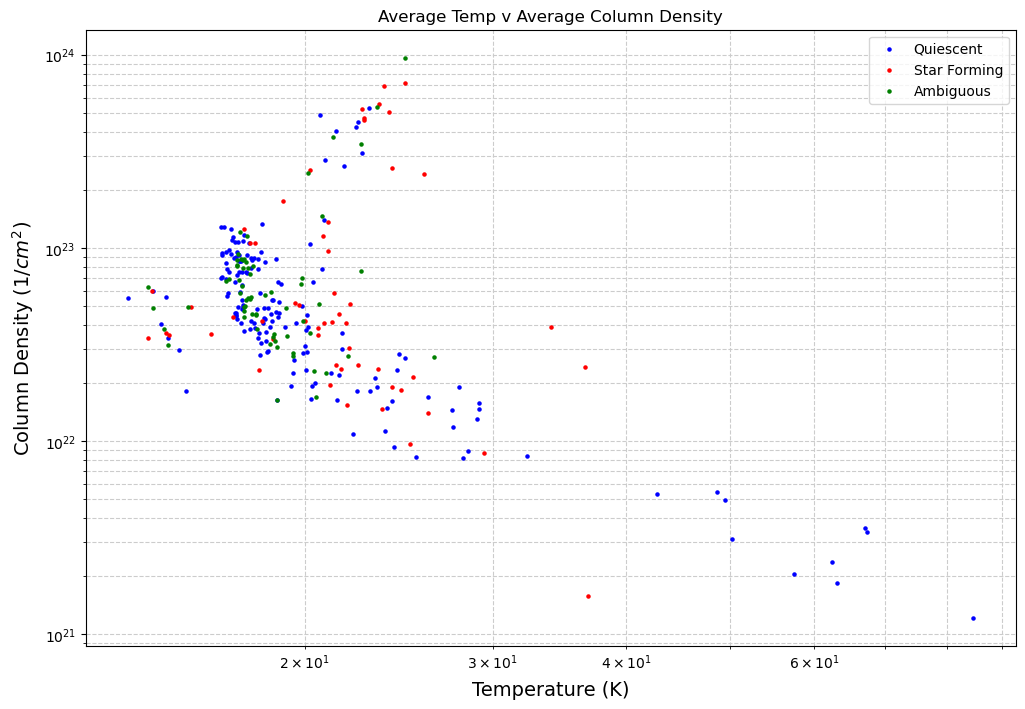

In [36]:
f, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12, 8))
ax.scatter(avg_T0, avg_N0, color='blue', s=5, label = 'Quiescent')
ax.scatter(avg_T1, avg_N1, color='red', s=5, label = 'Star Forming' )
ax.scatter(avg_T2, avg_N2, color='green', s=5, label = 'Ambiguous')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Temperature (K)', labelpad=6, fontsize=14)
ax.set_ylabel('Column Density (1/$cm^2$)', labelpad=6, fontsize=14)
ax.set_title('Average Temp v Average Column Density')
ax.grid(True, which="both", ls="--", color='0.80')
ax.legend()
plt.plot()

[]

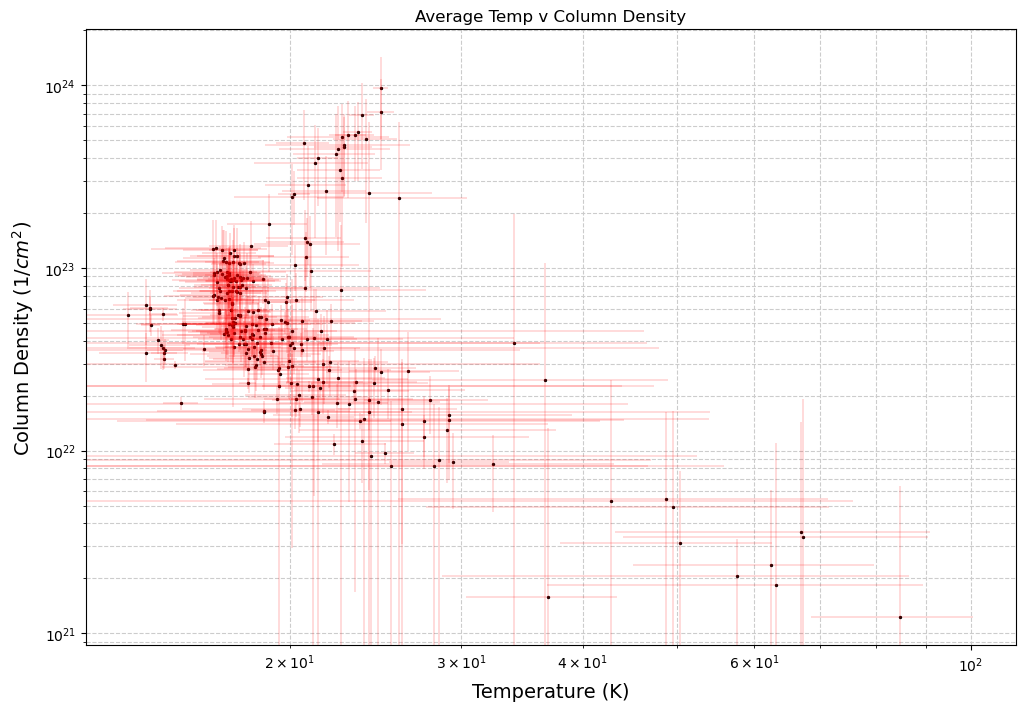

In [37]:
f, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12, 8))
ax.scatter(avg_temp, avg_dens, color='black', s=2)
ax.errorbar(avg_temp, avg_dens, yerr=uncert_avg_N, xerr= uncert_avg_T, ls='', elinewidth = .2, color = 'red')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Temperature (K)', labelpad=6, fontsize=14)
ax.set_ylabel('Column Density ($1/cm^2$)', labelpad=6, fontsize=14)
ax.set_title('Average Temp v Column Density')
ax.grid(True, which="both", ls="--", color='0.80')
plt.plot()

In [38]:
Avg_CSL0 = np.median(NL[np.where(Core_State == 0)])
Avg_CSL1 = np.median(NL[np.where(Core_State == 1)])
Avg_CSL2 = np.median(NL[np.where(Core_State == 2)])

Avg_TL0 = np.median(TL[np.where(Core_State == 0)])
Avg_TL1 = np.median(TL[np.where(Core_State == 1)])
Avg_TL2 = np.median(TL[np.where(Core_State == 2)])

[]

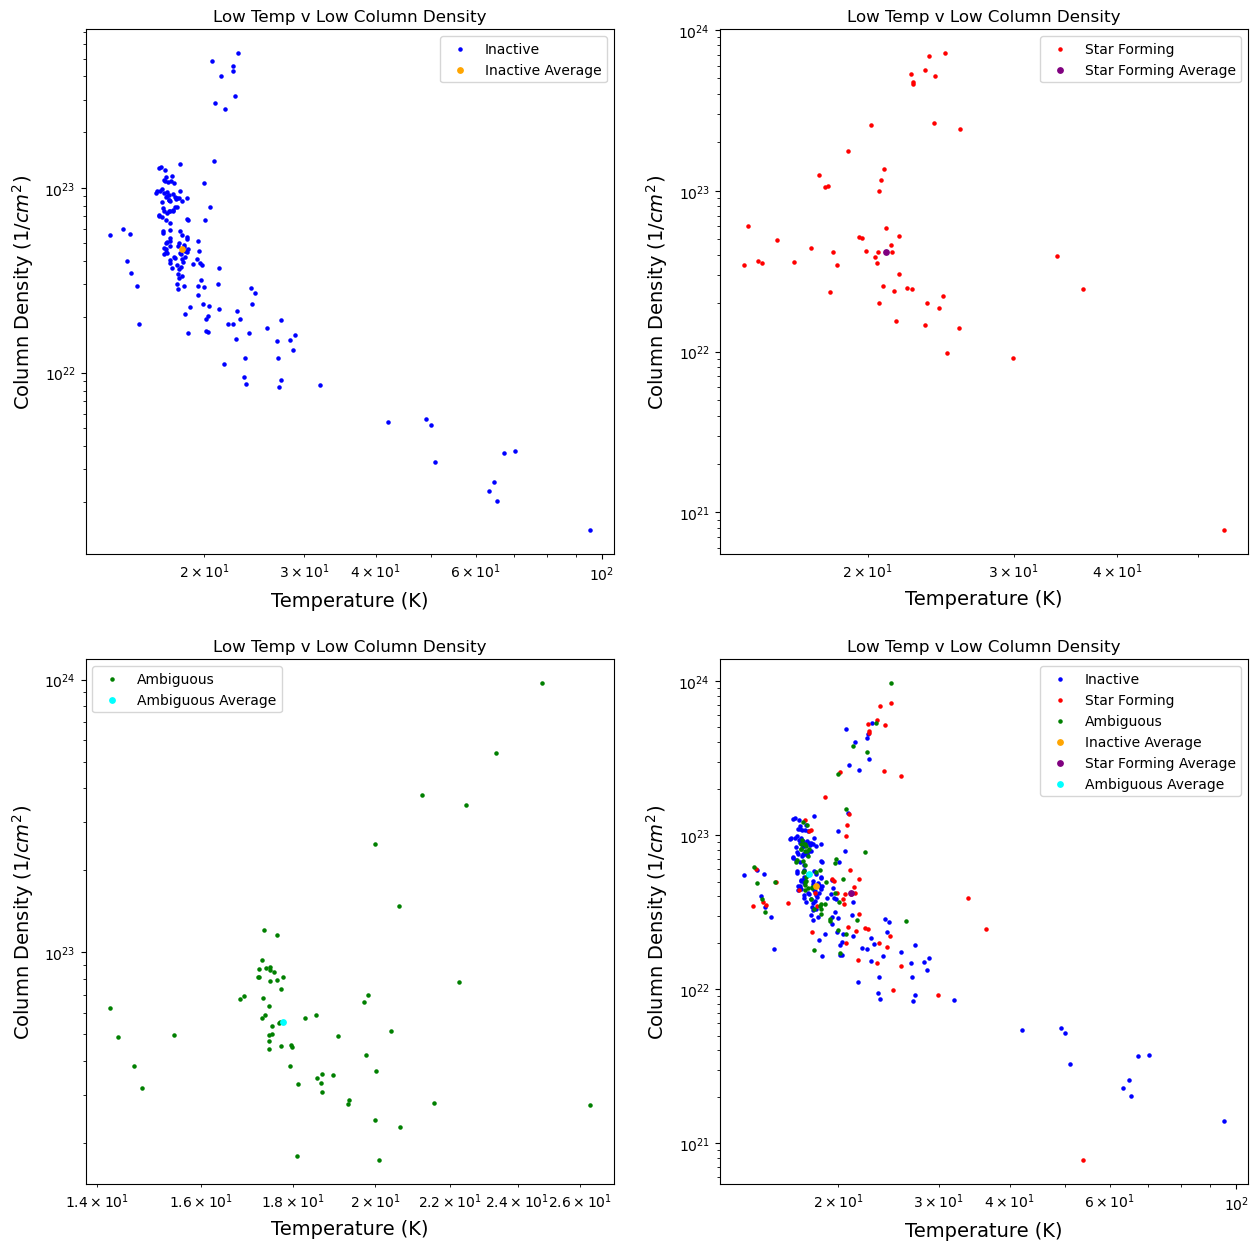

In [39]:

f, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 6))
ax[1,1].scatter(TL_0, NL_0, color='blue', s=5, label = 'Inactive')
ax[1,1].scatter(TL_1, NL_1, color='red', s=5, label = 'Star Forming' )
ax[1,1].scatter(TL_2, NL_2, color='green', s=5, label = 'Ambiguous')
ax[0,0].scatter(TL_0, NL_0, color='blue', s=5, label = 'Inactive')
ax[0,1].scatter(TL_1, NL_1, color='red', s=5, label = 'Star Forming' )
ax[1,0].scatter(TL_2, NL_2, color='green', s=5, label = 'Ambiguous')

ax[0,0].scatter(Avg_TL0, Avg_CSL0, color='orange', s=15, label = 'Inactive Average')
ax[0,1].scatter(Avg_TL1, Avg_CSL1, color='purple', s=15, label = 'Star Forming Average' )
ax[1,0].scatter(Avg_TL2, Avg_CSL2, color='cyan', s=15, label = 'Ambiguous Average')

ax[1,1].scatter(Avg_TL0, Avg_CSL0, color='orange', s=15, label = 'Inactive Average')
ax[1,1].scatter(Avg_TL1, Avg_CSL1, color='purple', s=15, label = 'Star Forming Average' )
ax[1,1].scatter(Avg_TL2, Avg_CSL2, color='cyan', s=15, label = 'Ambiguous Average')

#plt.xlim(-10, 200)
ax[0,0].set_yscale('log')
ax[0,1].set_yscale('log')
ax[1,0].set_yscale('log')
ax[1,1].set_yscale('log')
ax[0,0].set_xscale('log')
ax[0,1].set_xscale('log')
ax[1,0].set_xscale('log')
ax[1,1].set_xscale('log')
#plt.ylim(10e21, 10e28)
ax[0,0].set_xlabel('Temperature (K)', labelpad=6, fontsize=14)
ax[0,1].set_xlabel('Temperature (K)', labelpad=6, fontsize=14)
ax[1,0].set_xlabel('Temperature (K)', labelpad=6, fontsize=14)
ax[1,1].set_xlabel('Temperature (K)', labelpad=6, fontsize=14)
ax[0,0].set_ylabel('Column Density (1/$cm^2$)', labelpad=6, fontsize=14)
ax[0,1].set_ylabel('Column Density (1/$cm^2$)', labelpad=6, fontsize=14)
ax[1,0].set_ylabel('Column Density (1/$cm^2$)', labelpad=6, fontsize=14)
ax[1,1].set_ylabel('Column Density (1/$cm^2$)', labelpad=6, fontsize=14)
ax[0,0].set_title('Low Temp v Low Column Density')
ax[0,1].set_title('Low Temp v Low Column Density')
ax[1,0].set_title('Low Temp v Low Column Density')
ax[1,1].set_title('Low Temp v Low Column Density')
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()
f.set_figheight(15)
f.set_figwidth(15)
plt.plot()

In [40]:
NM_0 = (NM[np.where(Core_State == 0)])
NM_1 = (NM[np.where(Core_State == 1)])
NM_2 = (NM[np.where(Core_State == 2)])

TM_0 = (TM[np.where(Core_State == 0)])
TM_1 = (TM[np.where(Core_State == 1)])
TM_2 = (TM[np.where(Core_State == 2)])

UN_TM0 = (UN_TM[np.where(Core_State == 0)])
UN_TM1 = (UN_TM[np.where(Core_State == 1)])
UN_TM2 = (UN_TM[np.where(Core_State == 2)])

UN_NM0 = (UN_NM[np.where(Core_State == 0)])
UN_NM1 = (UN_NM[np.where(Core_State == 1)])
UN_NM2 = (UN_NM[np.where(Core_State == 2)])

In [41]:
Avg_CSM0 = np.median(NM[np.where(Core_State == 0)])
Avg_CSM1 = np.median(NM[np.where(Core_State == 1)])
Avg_CSM2 = np.median(NM[np.where(Core_State == 2)])

Avg_TM0 = np.median(TM[np.where(Core_State == 0)])
Avg_TM1 = np.median(TM[np.where(Core_State == 1)])
Avg_TM2 = np.median(TM[np.where(Core_State == 2)])

[]

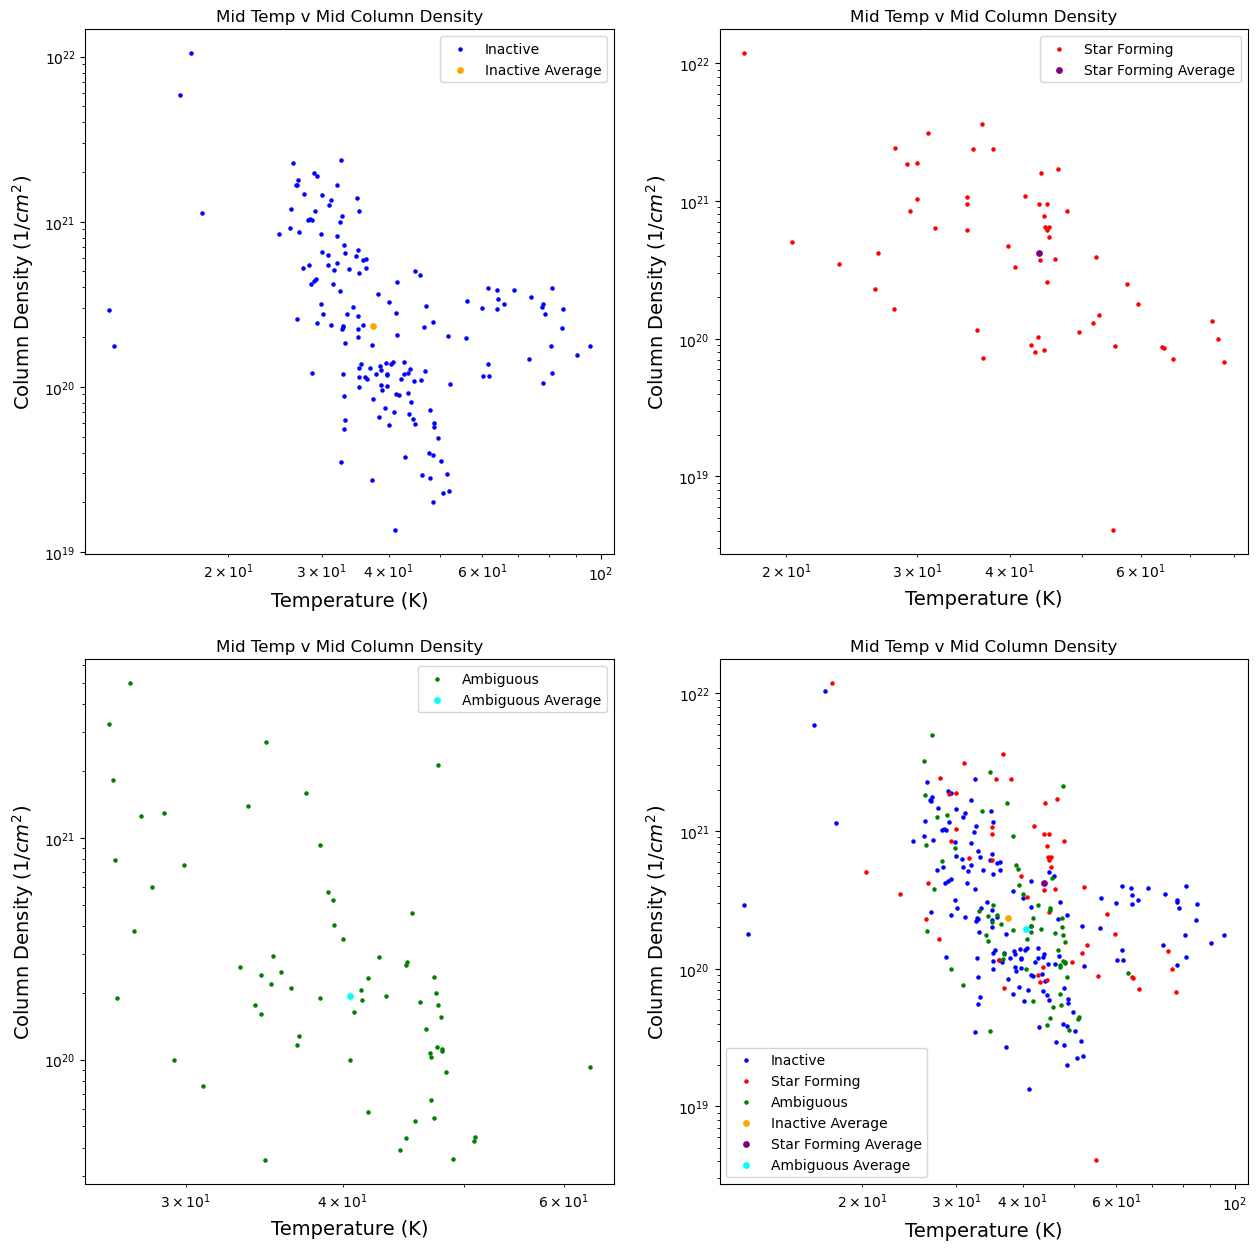

In [42]:
f, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 6))
ax[1,1].scatter(TM_0, NM_0, color='blue', s=5, label = 'Inactive')
ax[1,1].scatter(TM_1, NM_1, color='red', s=5, label = 'Star Forming' )
ax[1,1].scatter(TM_2, NM_2, color='green', s=5, label = 'Ambiguous')
ax[0,0].scatter(TM_0, NM_0, color='blue', s=5, label = 'Inactive')
ax[0,1].scatter(TM_1, NM_1, color='red', s=5, label = 'Star Forming' )
ax[1,0].scatter(TM_2, NM_2, color='green', s=5, label = 'Ambiguous')

ax[0,0].scatter(Avg_TM0, Avg_CSM0, color='orange', s=15, label = 'Inactive Average')
ax[0,1].scatter(Avg_TM1, Avg_CSM1, color='purple', s=15, label = 'Star Forming Average' )
ax[1,0].scatter(Avg_TM2, Avg_CSM2, color='cyan', s=15, label = 'Ambiguous Average')

ax[1,1].scatter(Avg_TM0, Avg_CSM0, color='orange', s=15, label = 'Inactive Average')
ax[1,1].scatter(Avg_TM1, Avg_CSM1, color='purple', s=15, label = 'Star Forming Average' )
ax[1,1].scatter(Avg_TM2, Avg_CSM2, color='cyan', s=15, label = 'Ambiguous Average')

#plt.xlim(-10, 200)
ax[0,0].set_yscale('log')
ax[0,1].set_yscale('log')
ax[1,0].set_yscale('log')
ax[1,1].set_yscale('log')
ax[0,0].set_xscale('log')
ax[0,1].set_xscale('log')
ax[1,0].set_xscale('log')
ax[1,1].set_xscale('log')
#plt.ylim(10e21, 10e28)
ax[0,0].set_xlabel('Temperature (K)', labelpad=6, fontsize=14)
ax[0,1].set_xlabel('Temperature (K)', labelpad=6, fontsize=14)
ax[1,0].set_xlabel('Temperature (K)', labelpad=6, fontsize=14)
ax[1,1].set_xlabel('Temperature (K)', labelpad=6, fontsize=14)
ax[0,0].set_ylabel('Column Density (1/$cm^2$)', labelpad=6, fontsize=14)
ax[0,1].set_ylabel('Column Density (1/$cm^2$)', labelpad=6, fontsize=14)
ax[1,0].set_ylabel('Column Density (1/$cm^2$)', labelpad=6, fontsize=14)
ax[1,1].set_ylabel('Column Density (1/$cm^2$)', labelpad=6, fontsize=14)
ax[0,0].set_title('Mid Temp v Mid Column Density')
ax[0,1].set_title('Mid Temp v Mid Column Density')
ax[1,0].set_title('Mid Temp v Mid Column Density')
ax[1,1].set_title('Mid Temp v Mid Column Density')
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()
f.set_figheight(15)
f.set_figwidth(15)
plt.plot()

In [43]:
NH_0 = (NH[np.where(Core_State == 0)])
NH_1 = (NH[np.where(Core_State == 1)])
NH_2 = (NH[np.where(Core_State == 2)])

TH_0 = (TH[np.where(Core_State == 0)])
TH_1 = (TH[np.where(Core_State == 1)])
TH_2 = (TH[np.where(Core_State == 2)])

UN_TH0 = (UN_TH[np.where(Core_State == 0)])
UN_TH1 = (UN_TH[np.where(Core_State == 1)])
UN_TH2 = (UN_TH[np.where(Core_State == 2)])

UN_NH0 = (UN_NH[np.where(Core_State == 0)])
UN_NH1 = (UN_NH[np.where(Core_State == 1)])
UN_NH2 = (UN_NH[np.where(Core_State == 2)])

In [44]:
Avg_CSH0 = np.median(NH[np.where(Core_State == 0)])
Avg_CSH1 = np.median(NH[np.where(Core_State == 1)])
Avg_CSH2 = np.median(NH[np.where(Core_State == 2)])

Avg_TH0 = np.median(TH[np.where(Core_State == 0)])
Avg_TH1 = np.median(TH[np.where(Core_State == 1)])
Avg_TH2 = np.median(TH[np.where(Core_State == 2)])

[]

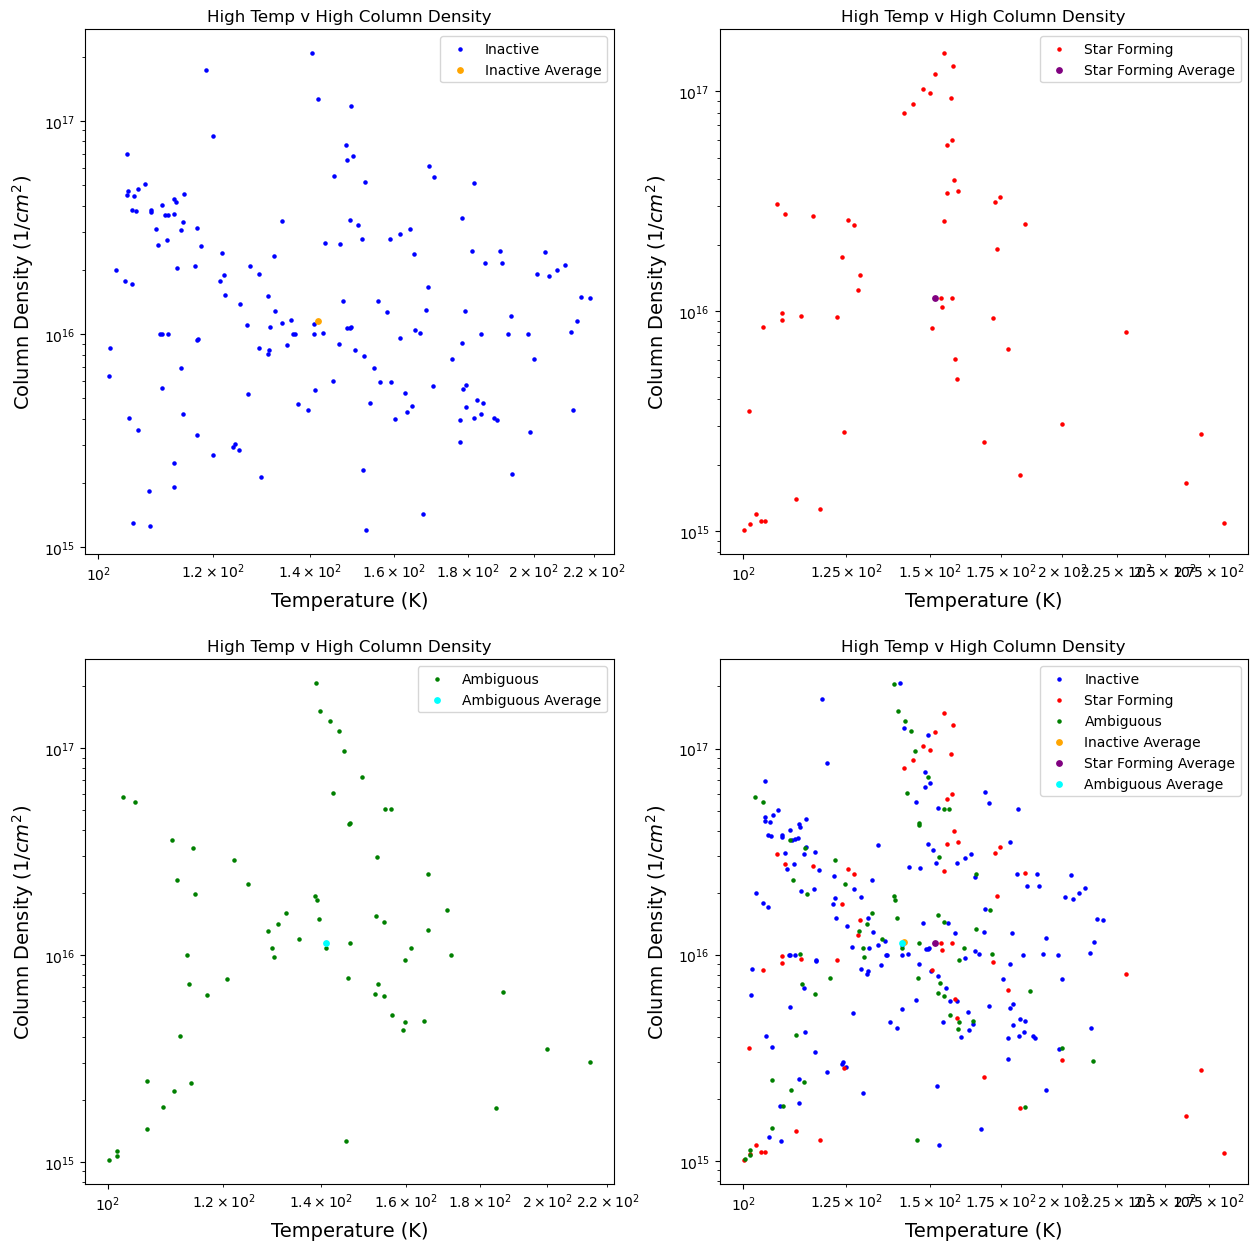

In [45]:
f, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 6))
ax[1,1].scatter(TH_0, NH_0, color='blue', s=5, label = 'Inactive')
ax[1,1].scatter(TH_1, NH_1, color='red', s=5, label = 'Star Forming' )
ax[1,1].scatter(TH_2, NH_2, color='green', s=5, label = 'Ambiguous')
ax[0,0].scatter(TH_0, NH_0, color='blue', s=5, label = 'Inactive')
ax[0,1].scatter(TH_1, NH_1, color='red', s=5, label = 'Star Forming' )
ax[1,0].scatter(TH_2, NH_2, color='green', s=5, label = 'Ambiguous')

ax[0,0].scatter(Avg_TH0, Avg_CSH0, color='orange', s=15, label = 'Inactive Average')
ax[0,1].scatter(Avg_TH1, Avg_CSH1, color='purple', s=15, label = 'Star Forming Average' )
ax[1,0].scatter(Avg_TH2, Avg_CSH2, color='cyan', s=15, label = 'Ambiguous Average')

ax[1,1].scatter(Avg_TH0, Avg_CSH0, color='orange', s=15, label = 'Inactive Average')
ax[1,1].scatter(Avg_TH1, Avg_CSH1, color='purple', s=15, label = 'Star Forming Average' )
ax[1,1].scatter(Avg_TH2, Avg_CSH2, color='cyan', s=15, label = 'Ambiguous Average')

#plt.xlim(-10, 200)
ax[0,0].set_yscale('log')
ax[0,1].set_yscale('log')
ax[1,0].set_yscale('log')
ax[1,1].set_yscale('log')
ax[0,0].set_xscale('log')
ax[0,1].set_xscale('log')
ax[1,0].set_xscale('log')
ax[1,1].set_xscale('log')
#plt.ylim(10e21, 10e28)
ax[0,0].set_xlabel('Temperature (K)', labelpad=6, fontsize=14)
ax[0,1].set_xlabel('Temperature (K)', labelpad=6, fontsize=14)
ax[1,0].set_xlabel('Temperature (K)', labelpad=6, fontsize=14)
ax[1,1].set_xlabel('Temperature (K)', labelpad=6, fontsize=14)
ax[0,0].set_ylabel('Column Density (1/$cm^2$)', labelpad=6, fontsize=14)
ax[0,1].set_ylabel('Column Density (1/$cm^2$)', labelpad=6, fontsize=14)
ax[1,0].set_ylabel('Column Density (1/$cm^2$)', labelpad=6, fontsize=14)
ax[1,1].set_ylabel('Column Density (1/$cm^2$)', labelpad=6, fontsize=14)
ax[0,0].set_title('High Temp v High Column Density')
ax[0,1].set_title('High Temp v High Column Density')
ax[1,0].set_title('High Temp v High Column Density')
ax[1,1].set_title('High Temp v High Column Density')
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()
f.set_figheight(15)
f.set_figwidth(15)
plt.plot()

In [46]:
NT_0 = (NL[np.where(Core_State == 0)]), (NM[np.where(Core_State == 0)]), (NH[np.where(Core_State == 0)])
NT_1 = (NL[np.where(Core_State == 1)]), (NM[np.where(Core_State == 1)]), (NH[np.where(Core_State == 1)])
NT_2 = (NL[np.where(Core_State == 2)]), (NM[np.where(Core_State == 2)]), (NH[np.where(Core_State == 2)])

TT_0 = (TL[np.where(Core_State == 0)]), (TM[np.where(Core_State == 0)]), (TH[np.where(Core_State == 0)])
TT_1 = (TL[np.where(Core_State == 1)]), (TM[np.where(Core_State == 1)]), (TH[np.where(Core_State == 1)])
TT_2 = (TL[np.where(Core_State == 2)]), (TM[np.where(Core_State == 2)]), (TH[np.where(Core_State == 2)])

[]

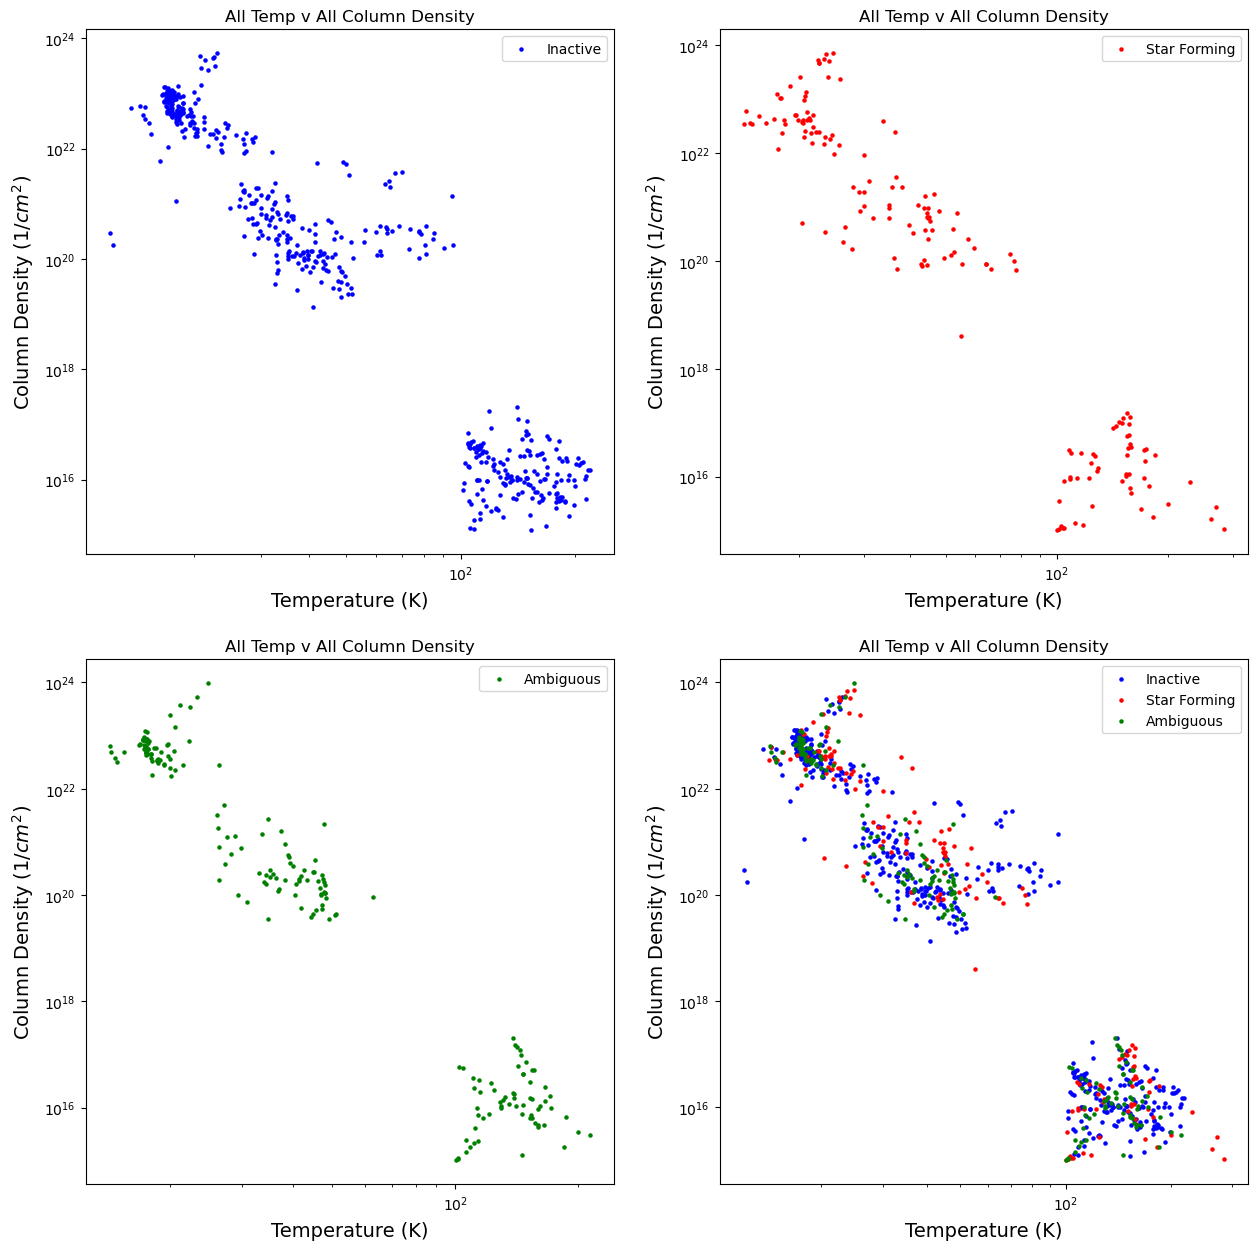

In [47]:
f, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 6))
ax[1,1].scatter(TT_0, NT_0, color='blue', s=5, label = 'Inactive')
ax[1,1].scatter(TT_1, NT_1, color='red', s=5, label = 'Star Forming' )
ax[1,1].scatter(TT_2, NT_2, color='green', s=5, label = 'Ambiguous')
ax[0,0].scatter(TT_0, NT_0, color='blue', s=5, label = 'Inactive')
ax[0,1].scatter(TT_1, NT_1, color='red', s=5, label = 'Star Forming' )
ax[1,0].scatter(TT_2, NT_2, color='green', s=5, label = 'Ambiguous')
#plt.xlim(-10, 200)
ax[0,0].set_yscale('log')
ax[0,1].set_yscale('log')
ax[1,0].set_yscale('log')
ax[1,1].set_yscale('log')
ax[0,0].set_xscale('log')
ax[0,1].set_xscale('log')
ax[1,0].set_xscale('log')
ax[1,1].set_xscale('log')
#plt.ylim(10e21, 10e28)
ax[0,0].set_xlabel('Temperature (K)', labelpad=6, fontsize=14)
ax[0,1].set_xlabel('Temperature (K)', labelpad=6, fontsize=14)
ax[1,0].set_xlabel('Temperature (K)', labelpad=6, fontsize=14)
ax[1,1].set_xlabel('Temperature (K)', labelpad=6, fontsize=14)
ax[0,0].set_ylabel('Column Density (1/$cm^2$)', labelpad=6, fontsize=14)
ax[0,1].set_ylabel('Column Density (1/$cm^2$)', labelpad=6, fontsize=14)
ax[1,0].set_ylabel('Column Density (1/$cm^2$)', labelpad=6, fontsize=14)
ax[1,1].set_ylabel('Column Density (1/$cm^2$)', labelpad=6, fontsize=14)
ax[0,0].set_title('All Temp v All Column Density')
ax[0,1].set_title('All Temp v All Column Density')
ax[1,0].set_title('All Temp v All Column Density')
ax[1,1].set_title('All Temp v All Column Density')
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()
f.set_figheight(15)
f.set_figwidth(15)
plt.plot()

In [48]:
print('Averages')
print('SF Regions')
print('Low Temp:')
print(Avg_TL1, Avg_CSL1)
print('Mid Temp:')
print(Avg_TM1, Avg_CSM1)
print('High Temp:')
print(Avg_TH1, Avg_CSH1)

print('Non SF Regions')
print('Low Temp:')
print(Avg_TL0, Avg_CSL0)
print('Mid Temp:')
print(Avg_TM0, Avg_CSM0)
print('High Temp:')
print(Avg_TH0, Avg_CSH0)

print('Uncertain Regions')
print('Low Temp:')
print(Avg_TL2, Avg_CSL2)
print('Mid Temp:')
print(Avg_TM2, Avg_CSM2)
print('High Temp:')
print(Avg_TH2, Avg_CSH2)

Averages
SF Regions
Low Temp:
21.018 4.180282335659523e+22
Mid Temp:
43.782 4.197034281270541e+20
High Temp:
151.633 1.1422863678409808e+16
Non SF Regions
Low Temp:
18.254 4.650845912007497e+22
Mid Temp:
37.478 2.325180490427861e+20
High Temp:
141.87 1.1461087265569656e+16
Uncertain Regions
Low Temp:
17.768 5.568164134560284e+22
Mid Temp:
40.538 1.942964880431514e+20
High Temp:
141.098 1.14387409887859e+16


In [53]:
x = catalog['index'][np.where(Core_State==0)]
y = catalog['index'][np.where(Core_State==1)]
z = catalog['index'][np.where(Core_State==2)]

ABBA_0 = catalog['DustTemperature'][np.isin(catalog['index'], x)]
ABBA_1 = catalog['DustTemperature'][np.isin(catalog['index'], y)]
ABBA_2 = catalog['DustTemperature'][np.isin(catalog['index'], z)]
DunkinDonuts = catalog['mass'][np.isin(catalog['index'], L3)]

In [54]:
avg_T0 = (avg_temp[np.where(Core_State == 0)])
avg_T1 = (avg_temp[np.where(Core_State == 1)])
avg_T2 = (avg_temp[np.where(Core_State == 2)])

avg_N0 = (avg_dens[np.where(Core_State == 0)])
avg_N1 = (avg_dens[np.where(Core_State == 1)])
avg_N2 = (avg_dens[np.where(Core_State == 2)])

[]

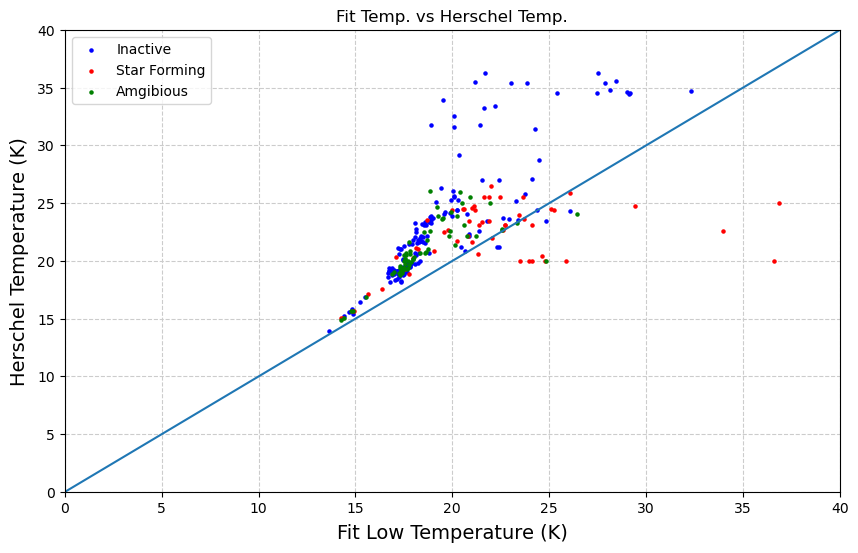

In [55]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 6))
ax.scatter(avg_T0, ABBA_0, color='blue', label = 'Inactive', s=5)
ax.scatter(avg_T1, ABBA_1, color='red', label = 'Star Forming', s=5)
ax.scatter(avg_T2, ABBA_2, color='green', label = 'Amgibious', s=5)
ax.axline((0, 0), slope=1)
ax.set_xlim(0, 40)
ax.set_ylim(0, 40)
ax.set_xlabel('Fit Low Temperature (K)', labelpad=6, fontsize=14)
ax.set_ylabel('Herschel Temperature (K)', labelpad=6, fontsize=14)
#plt.yscale('log')
#plt.xscale('log')
ax.set_title('Fit Temp. vs Herschel Temp.')
#ax.rc('axes', axisbelow=True)
ax.grid(True, which="both", ls="--", color='0.80')
plt.legend()
plt.plot()

[]

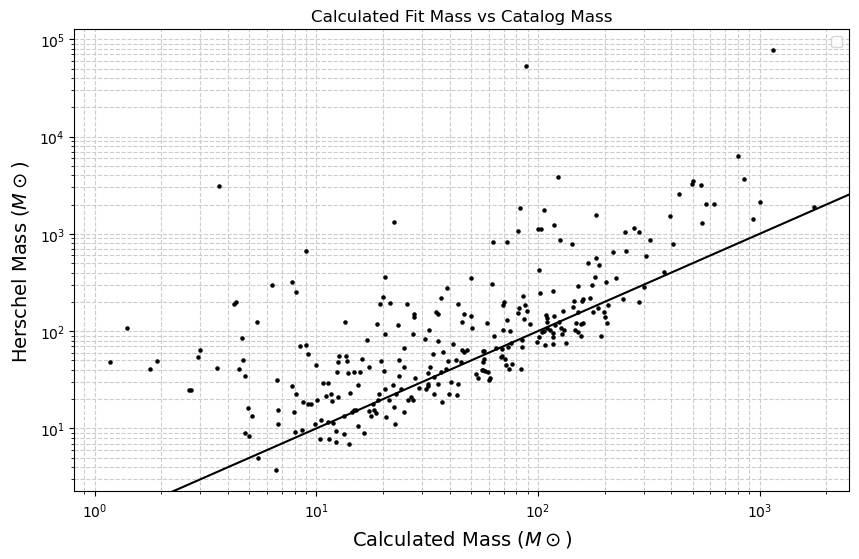

In [56]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 6))
ax.scatter(mass, DunkinDonuts, color='k', s=5)
ax.axline((0, 0), slope=1, color = 'k')
ax.set_xlabel('Calculated Mass ($M\odot$)', labelpad=6, fontsize=14)
ax.set_ylabel('Herschel Mass ($M\odot$)', labelpad=6, fontsize=14)
#ax.set_ylim()
plt.yscale('log')
plt.xscale('log')
ax.set_title('Calculated Fit Mass vs Catalog Mass')
#ax.rc('axes', axisbelow=True)
ax.grid(True, which="both", ls="--", color='0.80')
plt.legend()
plt.plot()